In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [4]:
file_path = r'D:\Khang\FPT semester\semester_4\DAP391m\final_project\.venv\final_attempt\fashion_US_UK.csv'

# Đọc dataset
df = pd.read_csv(file_path)
df 

,Product Name,Price,Brand,Category,Description,Rating,Review Count,Style Attributes,Total Sizes,Available Sizes,Color,Purchase History,Age,Fashion Magazines,Fashion Influencers,Season,Time Period Highest Purchase,Customer Reviews,Social Media Comments,feedback
0,T5D3,97.509966,Ralph Lauren,Footwear,Bad,1.421706,492,Streetwear,"M, L, XL",XL,Green,Medium,24,Vogue,Chiara Ferragni,Fall/Winter,Daytime,Mixed,Mixed,Other
1,Y0V7,52.341277,Ted Baker,Tops,Not Good,1.037677,57,Vintage,"M, L, XL",XL,Black,Above Average,61,Glamour,Leandra Medine,Winter,Weekend,Negative,Neutral,Other
2,N9Q4,15.430975,Jigsaw,Footwear,Very Bad,3.967106,197,Streetwear,"S, M, L",M,Blue,Average,27,Marie Claire,Gigi Hadid,Summer,Nighttime,Unknown,Negative,Neutral
3,V2T6,81.116542,Alexander McQueen,Outerwear,Not Good,2.844659,473,Formal,"S, M, L",L,Red,Very High,50,Marie Claire,Chiara Ferragni,Fall/Winter,Weekend,Neutral,Other,Other
4,S7Y1,31.633686,Tommy Hilfiger,Bottoms,Very Good,1.183242,55,Sporty,"M, L, XL",S,Green,Above Average,23,Glamour,Song of Style,Spring,Daytime,Positive,Mixed,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,K9C7,16.255998,Mulberry,Accessories,Best,3.534252,312,Vintage,"S, L, XL",XL,Green,Very High,37,Cosmopolitan,Olivia Palermo,Winter,Holiday,Positive,Negative,Positive
999996,E5I5,78.555545,Mulberry,Activewear,Best,1.896160,68,Casual,"S, M, L",L,Red,Average,52,Glamour,Kendall Jenner,Spring,Evening,Unknown,Other,Neutral
999997,Y0C9,34.379639,Mulberry,Tops,Not Good,3.168064,237,Casual,"S, M, L",M,Red,High,25,Cosmopolitan,Leandra Medine,Summer,Evening,Neutral,Mixed,Unknown
999998,B1D8,62.343618,Ralph Lauren,Tops,Best,4.764673,53,Sporty,"M, L, XL",S,Red,Above Average,29,W,Olivia Palermo,Spring/Summer,Evening,Positive,Other,Other


In [5]:
# Xử lý feature 'Fashion Magazines', 'Fashion Influencers' -> gộp lại thành số lần được nhắc đến của sản phẩm

# Xác định sản phẩm bằng tổ hợp các thuộc tính
product_features = ["Brand", "Category", "Style Attributes", "Color", "Season"]

# Tạo một cột duy nhất đại diện cho mỗi sản phẩm
df["Product_ID"] = df[product_features].astype(str).agg('-'.join, axis=1)

# Đếm số lần mỗi sản phẩm xuất hiện trong Fashion Magazines và Fashion Influencers
magazine_counts = df.groupby("Product_ID")["Fashion Magazines"].count()
influencer_counts = df.groupby("Product_ID")["Fashion Influencers"].count()

# Gán số lần xuất hiện vào dataset
df["Magazine Mentions"] = df["Product_ID"].map(magazine_counts)
df["Influencer Mentions"] = df["Product_ID"].map(influencer_counts)

# Tính tổng số lần nhắc đến
df["Total Mentions"] = df["Magazine Mentions"] + df["Influencer Mentions"]

# Xóa cột Product_ID vì chỉ dùng để tính toán
df.drop(columns=["Product_ID"], inplace=True)

df

,Product Name,Price,Brand,Category,Description,Rating,Review Count,Style Attributes,Total Sizes,Available Sizes,...,Fashion Magazines,Fashion Influencers,Season,Time Period Highest Purchase,Customer Reviews,Social Media Comments,feedback,Magazine Mentions,Influencer Mentions,Total Mentions
0,T5D3,97.509966,Ralph Lauren,Footwear,Bad,1.421706,492,Streetwear,"M, L, XL",XL,...,Vogue,Chiara Ferragni,Fall/Winter,Daytime,Mixed,Mixed,Other,60,60,120
1,Y0V7,52.341277,Ted Baker,Tops,Not Good,1.037677,57,Vintage,"M, L, XL",XL,...,Glamour,Leandra Medine,Winter,Weekend,Negative,Neutral,Other,56,56,112
2,N9Q4,15.430975,Jigsaw,Footwear,Very Bad,3.967106,197,Streetwear,"S, M, L",M,...,Marie Claire,Gigi Hadid,Summer,Nighttime,Unknown,Negative,Neutral,51,51,102
3,V2T6,81.116542,Alexander McQueen,Outerwear,Not Good,2.844659,473,Formal,"S, M, L",L,...,Marie Claire,Chiara Ferragni,Fall/Winter,Weekend,Neutral,Other,Other,50,50,100
4,S7Y1,31.633686,Tommy Hilfiger,Bottoms,Very Good,1.183242,55,Sporty,"M, L, XL",S,...,Glamour,Song of Style,Spring,Daytime,Positive,Mixed,Positive,60,60,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,K9C7,16.255998,Mulberry,Accessories,Best,3.534252,312,Vintage,"S, L, XL",XL,...,Cosmopolitan,Olivia Palermo,Winter,Holiday,Positive,Negative,Positive,49,49,98
999996,E5I5,78.555545,Mulberry,Activewear,Best,1.896160,68,Casual,"S, M, L",L,...,Glamour,Kendall Jenner,Spring,Evening,Unknown,Other,Neutral,57,57,114
999997,Y0C9,34.379639,Mulberry,Tops,Not Good,3.168064,237,Casual,"S, M, L",M,...,Cosmopolitan,Leandra Medine,Summer,Evening,Neutral,Mixed,Unknown,67,67,134
999998,B1D8,62.343618,Ralph Lauren,Tops,Best,4.764673,53,Sporty,"M, L, XL",S,...,W,Olivia Palermo,Spring/Summer,Evening,Positive,Other,Other,54,54,108


In [6]:
# Xác định ngưỡng median cho Review Count, Total Mentions
review_mean = df["Review Count"].mean()
mention_mean = df["Total Mentions"].mean()

# Xác định các giá trị thỏa mãn điều kiện
valid_purchase_history = {"Above Average", "Very High", "Significant", "High"}
valid_reviews = {'Positive'}
valid_comments = {'Positive'}
valid_feedback = {'Positive'}

# Tạo cột Trend dựa trên các điều kiện
df["Trend"] = (
    (df['Total Mentions'] > mention_mean) &
    (df["Review Count"] > review_mean) &
    (df["Purchase History"].isin(valid_purchase_history)) &
    (df['Customer Reviews'].isin(valid_reviews)) &
    (df['Social Media Comments'].isin(valid_comments)) &
    (df['feedback'].isin(valid_feedback))
).astype(int)  # Chuyển thành 0 hoặc 1

# Kiểm tra kết quả
df[["Purchase History","Review Count",'Customer Reviews','Social Media Comments','feedback', 'Total Mentions','Trend']].head()

,Purchase History,Review Count,Customer Reviews,Social Media Comments,feedback,Total Mentions,Trend
0,Medium,492,Mixed,Mixed,Other,120,0
1,Above Average,57,Negative,Neutral,Other,112,0
2,Average,197,Unknown,Negative,Neutral,102,0
3,Very High,473,Neutral,Other,Other,100,0
4,Above Average,55,Positive,Mixed,Positive,120,0


In [7]:
df['Trend'].value_counts()

Trend
0    999472
1       528
Name: count, dtype: int64

In [8]:
df[df['Trend'] == 1]

,Product Name,Price,Brand,Category,Description,Rating,Review Count,Style Attributes,Total Sizes,Available Sizes,...,Fashion Influencers,Season,Time Period Highest Purchase,Customer Reviews,Social Media Comments,feedback,Magazine Mentions,Influencer Mentions,Total Mentions,Trend
1964,Y9X4,71.406653,Alexander McQueen,Activewear,Very Good,2.281280,299,Bohemian,"S, L, XL",S,...,Song of Style,Winter,Daytime,Positive,Positive,Positive,62,62,124,1
2508,Q0N8,61.620157,Burberry,Accessories,Worst,3.775456,327,Formal,"S, L, XL",XL,...,Negin Mirsalehi,Summer,Holiday,Positive,Positive,Positive,67,67,134,1
5813,B1B3,87.536981,Jigsaw,Swimwear,Best,2.966894,441,Edgy,"M, L, XL",M,...,Olivia Palermo,Spring,Holiday,Positive,Positive,Positive,56,56,112,1
7434,O5S8,56.801062,Jigsaw,Dresses,Good,4.156920,361,Preppy,"S, M, L",S,...,Gigi Hadid,Spring,Nighttime,Positive,Positive,Positive,61,61,122,1
7668,H8S0,27.115593,Ralph Lauren,Bottoms,Good,4.909924,321,Vintage,"S, L, XL",XL,...,Gigi Hadid,Winter,Weekend,Positive,Positive,Positive,54,54,108,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991976,T5W7,48.245084,Jigsaw,Dresses,Best,3.913038,452,Edgy,"M, L, XL",S,...,Julie Sariñana,Fall,Weekend,Positive,Positive,Positive,64,64,128,1
994273,Y6V2,52.170339,Ted Baker,Activewear,Not Good,1.522457,455,Glamorous,"S, M, L",XL,...,Chiara Ferragni,Spring/Summer,Evening,Positive,Positive,Positive,64,64,128,1
996777,M8L1,54.377940,Alexander McQueen,Dresses,Good,4.586676,388,Glamorous,"S, L, XL",S,...,Aimee Song,Fall/Winter,Nighttime,Positive,Positive,Positive,58,58,116,1
999030,H5J5,65.237696,Ted Baker,Tops,Best,4.498014,307,Formal,"S, L, XL",S,...,Leandra Medine,Winter,Nighttime,Positive,Positive,Positive,57,57,114,1


In [9]:
df = df.drop(columns = ["Description", "Purchase History", "Review Count", "Rating", 'Product Name', 'Total Sizes',
                        'Available Sizes','Age','Fashion Magazines','Fashion Influencers', 'Time Period Highest Purchase',	
                        'Customer Reviews',	'Social Media Comments','feedback', 'Magazine Mentions','Influencer Mentions','Total Mentions'])

In [10]:
df.Price = round(df.Price, 2)

In [11]:
df

,Price,Brand,Category,Style Attributes,Color,Season,Trend
0,97.51,Ralph Lauren,Footwear,Streetwear,Green,Fall/Winter,0
1,52.34,Ted Baker,Tops,Vintage,Black,Winter,0
2,15.43,Jigsaw,Footwear,Streetwear,Blue,Summer,0
3,81.12,Alexander McQueen,Outerwear,Formal,Red,Fall/Winter,0
4,31.63,Tommy Hilfiger,Bottoms,Sporty,Green,Spring,0
...,...,...,...,...,...,...,...
999995,16.26,Mulberry,Accessories,Vintage,Green,Winter,0
999996,78.56,Mulberry,Activewear,Casual,Red,Spring,0
999997,34.38,Mulberry,Tops,Casual,Red,Summer,0
999998,62.34,Ralph Lauren,Tops,Sporty,Red,Spring/Summer,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Price             1000000 non-null  float64
 1   Brand             1000000 non-null  object 
 2   Category          1000000 non-null  object 
 3   Style Attributes  1000000 non-null  object 
 4   Color             1000000 non-null  object 
 5   Season            1000000 non-null  object 
 6   Trend             1000000 non-null  int32  
dtypes: float64(1), int32(1), object(5)
memory usage: 49.6+ MB


In [13]:
lb = LabelEncoder()
df_encoded = df.copy()
feature_categories = df_encoded.select_dtypes(include = ['object']).columns
# Tạo dictionary để lưu LabelEncoders cho từng cột
encoders = {}

for col in feature_categories:
    le = LabelEncoder()  # Tạo một LabelEncoder mới cho mỗi cột
    df_encoded[col] = le.fit_transform(df_encoded[col])  
    encoders[col] = le  # Lưu lại encoder cho cột đó

In [14]:
pickle.dump(encoders, open('encoders.pkl', 'wb'))

In [15]:
feature = df_encoded.drop(columns = ['Trend'])
label = df_encoded['Trend']

In [16]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Price             1000000 non-null  float64
 1   Brand             1000000 non-null  int32  
 2   Category          1000000 non-null  int32  
 3   Style Attributes  1000000 non-null  int32  
 4   Color             1000000 non-null  int32  
 5   Season            1000000 non-null  int32  
 6   Trend             1000000 non-null  int32  
dtypes: float64(1), int32(6)
memory usage: 30.5 MB


In [17]:
# undersample = RandomUnderSampler(sampling_strategy = 1, random_state=42) 
# X_resampled, y_resampled = undersample.fit_resample(feature, label)
oversample = SMOTE(sampling_strategy=1, random_state=42)
X_resampled, y_resampled = oversample.fit_resample(feature, label)

In [18]:
X_resampled.shape

(1998944, 6)

In [19]:
y_resampled.value_counts()

Trend
0    999472
1    999472
Name: count, dtype: int64

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 2)

In [21]:
XGB = XGBClassifier(
    n_estimators=100,
    max_depth=10,                # Độ sâu của cây(cân bằng giữa việc mô hình có thể học được các mẫu phức tạp mà không dẫn đến overfitting)
    learning_rate=0.3,          # Giúp mô hình học nhanh hơn
    subsample=1,                # Toàn bộ dữ liệu được sử dụng
    colsample_bytree=1,         # Sử dụng tất cả các feature trong cây   
)

XGB.fit(X_train, y_train)
y_pred = XGB.predict(X_test)
y_prob = XGB.predict_proba(X_test)[:,1]

results = list(zip(y_pred, y_prob))

# In kết quả
for pred, confidence in results[:10]:
    print(f"Prediction: {pred}, Confidence: {confidence:.4f}")

Prediction: 1, Confidence: 0.9892
Prediction: 0, Confidence: 0.0000
Prediction: 0, Confidence: 0.0001
Prediction: 1, Confidence: 0.9915
Prediction: 1, Confidence: 0.9057
Prediction: 0, Confidence: 0.0128
Prediction: 1, Confidence: 0.9826
Prediction: 0, Confidence: 0.0055
Prediction: 1, Confidence: 0.9804
Prediction: 0, Confidence: 0.0000


In [22]:
pickle.dump(XGB, open('fashion_trend_model.pkl', 'wb'))

In [23]:
class_rp = classification_report(y_test,y_pred)

accuracy = accuracy_score(y_test,y_pred)

print(class_rp)
print('Accuracy:',accuracy)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    300030
           1       0.98      1.00      0.99    299654

    accuracy                           0.99    599684
   macro avg       0.99      0.99      0.99    599684
weighted avg       0.99      0.99      0.99    599684

Accuracy: 0.9889691904402985


In [24]:
cv_scores = cross_val_score(XGB, X_resampled, y_resampled, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

Cross-validation scores: [0.98914177 0.99000473 0.98974959 0.98942692 0.989627  ]
Mean CV Accuracy: 0.9896


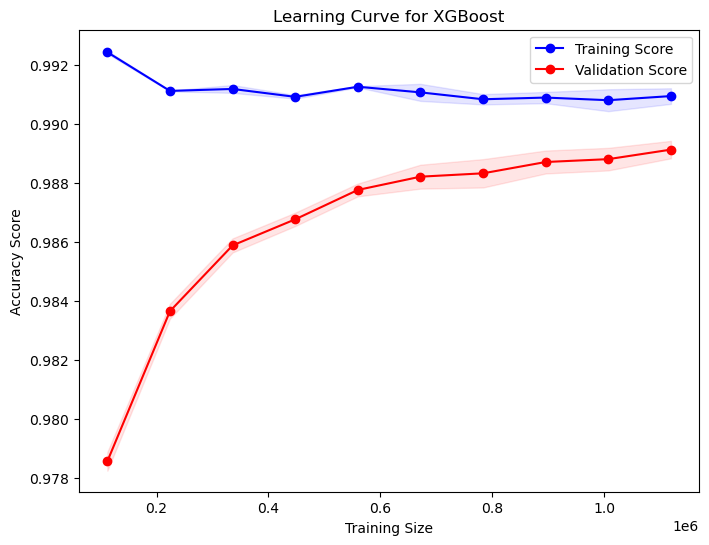

In [25]:
# Tính toán Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    XGB, X_train, y_train, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10)
)

# Tính trung bình & độ lệch chuẩn
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Vẽ Learning Curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, "o-", color="b", label="Training Score")
plt.plot(train_sizes, val_mean, "o-", color="r", label="Validation Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="b")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="r")
plt.xlabel("Training Size")
plt.ylabel("Accuracy Score")
plt.title("Learning Curve for XGBoost")
plt.legend(loc="best")
plt.show()

Train AUC: 1.00
Test AUC: 1.00


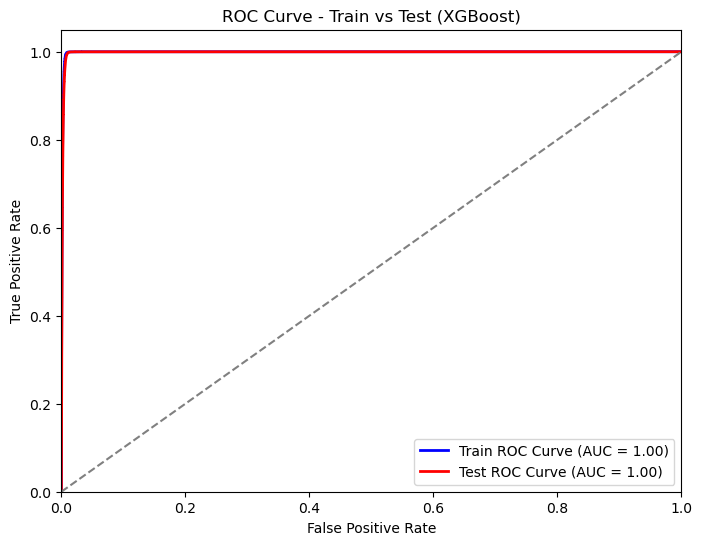

In [26]:
# Dự đoán xác suất trên tập train & test
y_train_probs = XGB.predict_proba(X_train)[:, 1]  # Train
y_test_probs = XGB.predict_proba(X_test)[:, 1]    # Test

# Tính ROC Curve cho train & test
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
roc_auc_test = auc(fpr_test, tpr_test)

print(f"Train AUC: {roc_auc_train:.2f}")
print(f"Test AUC: {roc_auc_test:.2f}")

# Vẽ ROC AUC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color="blue", lw=2, label=f"Train ROC Curve (AUC = {roc_auc_train:.2f})")
plt.plot(fpr_test, tpr_test, color="red", lw=2, label=f"Test ROC Curve (AUC = {roc_auc_test:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Đường baseline
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Train vs Test (XGBoost)")
plt.legend(loc="lower right")
plt.show()

In [27]:
import time
import psutil

# Bắt đầu đo thời gian và tài nguyên
cpu_usage = []
memory_usage_mb = []
start_time = time.time()

# Hàm lấy CPU và RAM mỗi 0.5s trong khi train
def monitor_resources():
    process = psutil.Process()  # Lấy tiến trình hiện tại
    while training:
        cpu_usage.append(psutil.cpu_percent(interval=0.5))
        memory_usage_mb.append(process.memory_info().rss / (1024 * 1024))  # Chuyển RAM từ bytes -> MB

# Chạy quá trình theo dõi tài nguyên song song với việc train
import threading
training = True
monitor_thread = threading.Thread(target=monitor_resources)
monitor_thread.start()

# Train mô hình
XGB.fit(X_train, y_train)

# Kết thúc theo dõi
training = False
monitor_thread.join()
end_time = time.time()

# Tính toán trung bình tài nguyên tiêu tốn
avg_cpu = np.mean(cpu_usage)
avg_ram_mb = np.mean(memory_usage_mb)
train_time = end_time - start_time

# In kết quả
print(f"Training time: {train_time:.2f} seconds")
print(f"Average CPU usage: {avg_cpu:.2f}%")
print(f"Average RAM usage: {avg_ram_mb:.2f} MB")

Training time: 6.03 seconds
Average CPU usage: 81.82%
Average RAM usage: 795.71 MB


In [28]:
# Save encoder into pkl file
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(XGB, f)

In [29]:
# Save model into pkl file
import pickle
pickle.dump(XGB, open('fashion_trend_model.pkl', 'wb'))
